## Goal of Models and Data

We plan to train two model that will work sequentially, one model will input raw mammogram images and attempt to output the shape of the mass detected in the image as a mask image. The masked images are already provided as a target variable. We will then take the output of the first model and run it through a classifier model to determine the class of the masked image: benign, malignant, or normal (cyst / non-cancerous growth).

In [ ]:
import tensorflow as tf
import numpy as np
import seaborn as sns
import pandas as pd
import random
import matplotlib.pyplot as plt
import pathlib
import cv2
import string
from sklearn.model_selection import train_test_split
import torch
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torchvision.models as models
from torchvision.models import ResNet18_Weights, resnet18
import os
from google.colab import drive

drive.mount('/content/drive')
!ls "/content/drive/MyDrive/BreastCancerProject/Datasets"

dir = '/content/drive/MyDrive/BreastCancerProject/Datasets'
datasetpath = os.path.join(dir, 'mammograms_2')

Mounted at /content/drive
 Mammograms   mammograms_2  'Potential Breast Cancer Datasets.docx'


In [ ]:
class read_dataset:
    def __init__(self, datasetpath, imageShape):
        self.datasetpath = datasetpath
        self.imageShape = imageShape

    def images_path(self, folder, name):
        images = list(pathlib.Path(os.path.join(self.datasetpath, folder)).glob('*{}.*'.format(name)))
        return images

    def read_images(self, images, channels):
        listImages = []
        images = np.sort(images)
        for image in images:
            image = tf.io.read_file(str(image))
            image = tf.image.decode_png(image, channels=channels)
            image = tf.image.resize(image, self.imageShape)
            image = image / 255.0
            listImages.append(image)
        return listImages

    def full_dataset(self, label):
        images = self.read_images(self.images_path(label, name=')'), channels=3)
        masks = np.array(self.read_images(self.images_path(label, name='mask'), channels=1))
        masks = (masks >= 0.5).astype('int32')
        return np.array(images), masks

    def final_dataset(self, labels):
        benign_images, benign_masks = self.full_dataset(labels[0])
        malignant_images, malignant_masks = self.full_dataset(labels[1])
        normal_images, normal_masks = self.full_dataset(labels[2])
        masks = np.vstack([benign_masks, malignant_masks, normal_masks])
        images = np.vstack([benign_images, malignant_images, normal_images])
        labels = np.hstack([
            np.ones(shape=(len(benign_images),)) * 0,
            np.ones(shape=(len(malignant_images),)) * 1,
            np.ones(shape=(len(normal_images),)) * 2
        ])
        return images, masks, labels

dataset_obj = read_dataset(datasetpath, [256, 256])
images, masks, labels = dataset_obj.final_dataset(['benign', 'malignant', 'normal'])

indices = np.random.permutation(len(images))
images = images[indices]
masks = masks[indices]
labels = labels[indices]

## Data Shape

The image data in RGB format, and the mask data is in greyscale which should be accounted for when considering running the model, as the output of the mask in training cannot be in RGB format.

In [ ]:
print('Shape of original mammogram dataset:', images.shape)
print('Shape of mask dataset:', masks.shape)
print('Shape of label dataset:', labels.shape)

Shape of original mammogram dataset: (1090, 256, 256, 3)
Shape of mask dataset: (1090, 256, 256, 1)
Shape of label dataset: (1090,)


## Data Samples

There are 1090 total samples in this dataset (original raw feature images). Of the three classes, there are 277 benign images, 315 malignant images, and 498 normal images (do not contain a growth, or contain non-cancerous cysts /
growths).

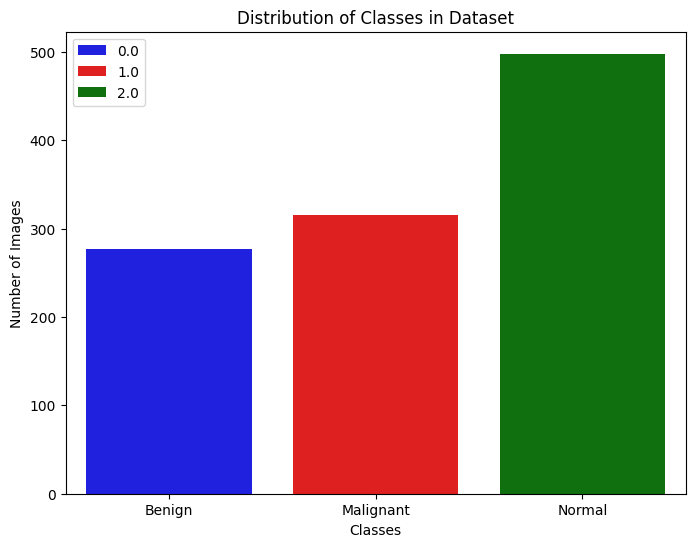

In [ ]:
unique_labels, label_counts = np.unique(labels, return_counts=True)
plt.figure(figsize=(8, 6))
sns.barplot(x=unique_labels, y=label_counts, hue=unique_labels, palette=['blue', 'red', 'green'])
plt.xticks(unique_labels, ['Benign', 'Malignant', 'Normal'])
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.title("Distribution of Classes in Dataset")
plt.show()

## Data Visualization

Overlaying the masked images (target values) on the original mammograms (feature values). The masked images are essentially the outline of the growth shown in the images. Some images do not contain a growth of any sort and those will all be classified as normal (some normal images have non-cancerous growths).

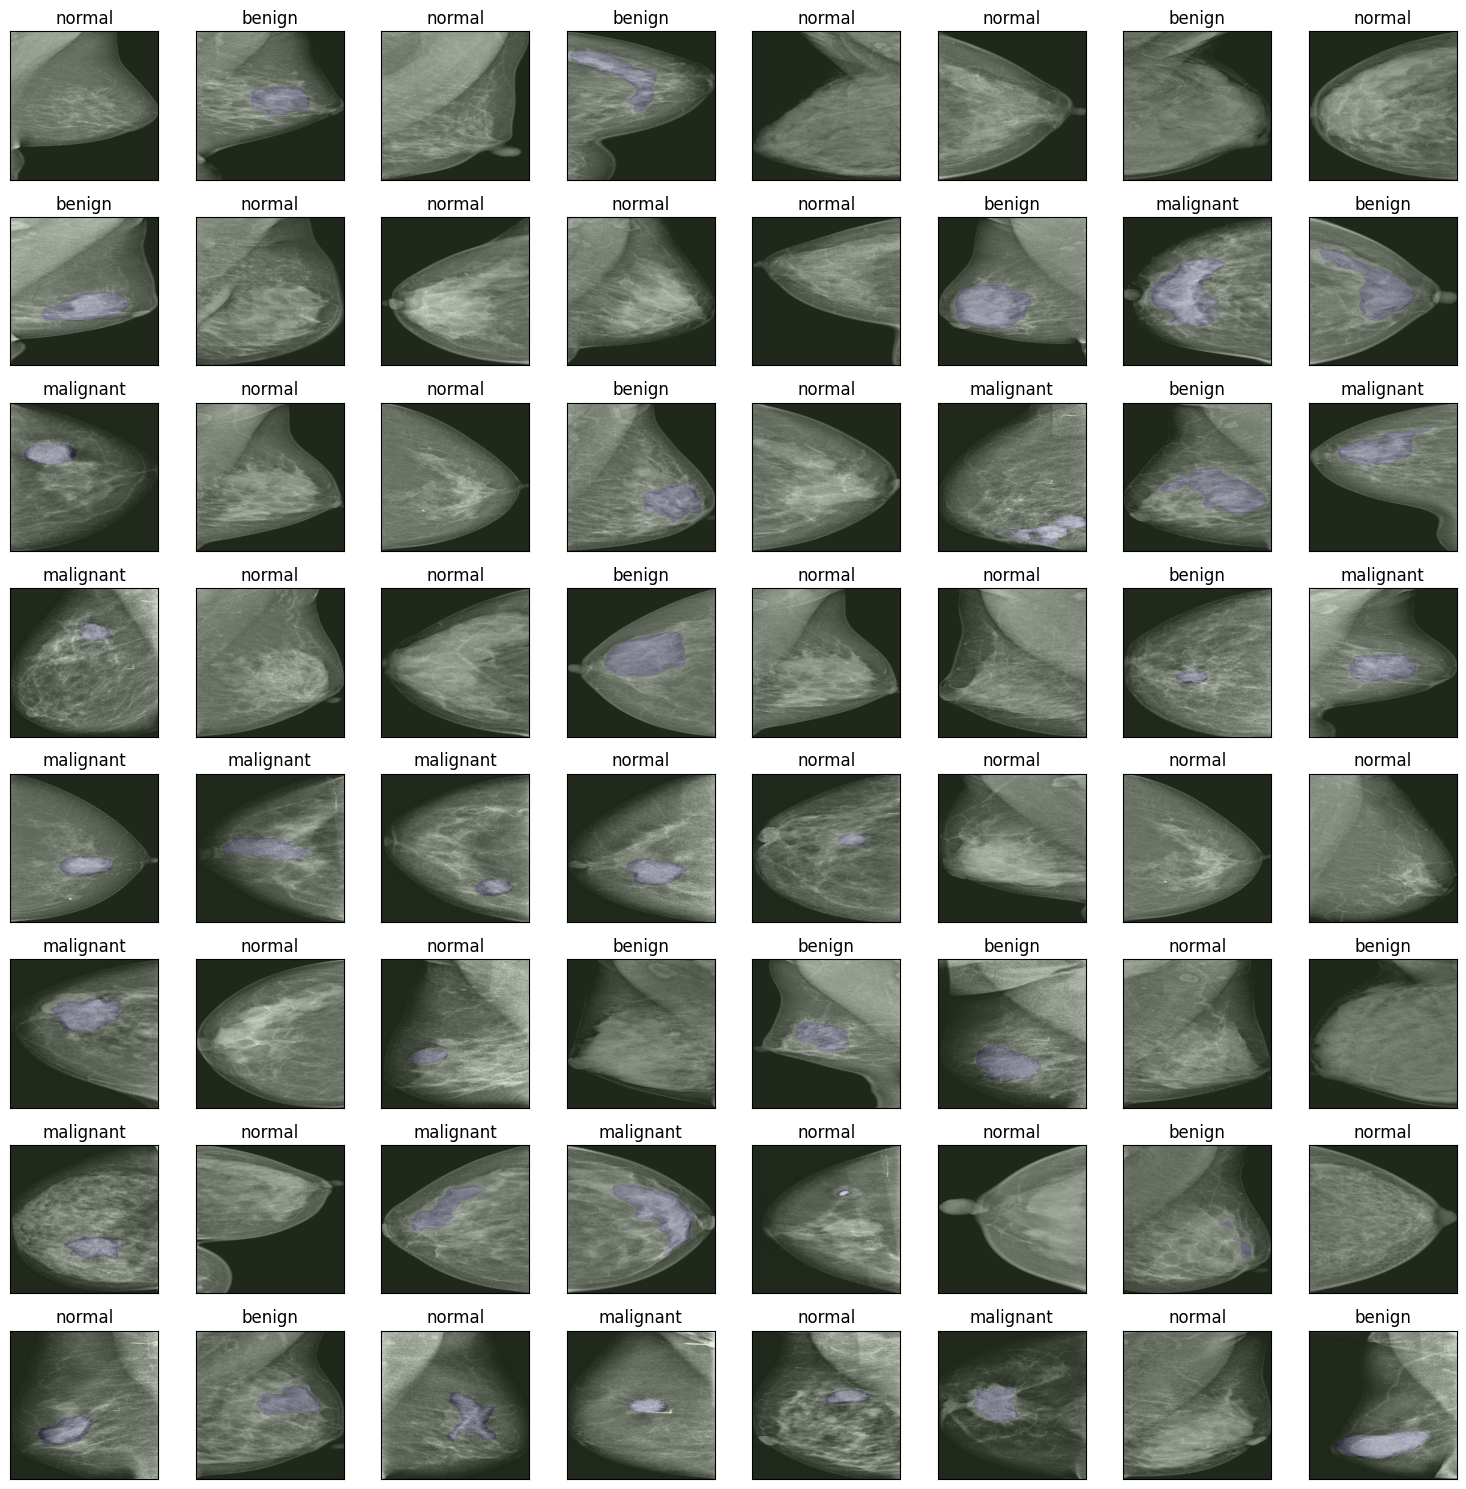

In [ ]:
def labeler(labels):
    if labels == 0:
        return 'benign'
    elif labels == 1:
        return 'malignant'
    else:
        return 'normal'

def plot_random_images(images, masks, labels, num_images=100):
    num_images = min(num_images, images.shape[0], masks.shape[0])
    random_indices = random.sample(range(images.shape[0]), num_images)

    plt.figure(figsize=(15, 15))
    for i, index in enumerate(random_indices):
        plt.subplot(8, 8, (i + 1))
        plt.imshow(images[i])
        plt.imshow(masks[i], alpha=0.2, cmap='crest')
        plt.xticks([])
        plt.yticks([])
        plt.title(labeler(labels[i]))

    plt.tight_layout()
    plt.show()

plot_random_images(images[:64], masks[:64], labels[:64])

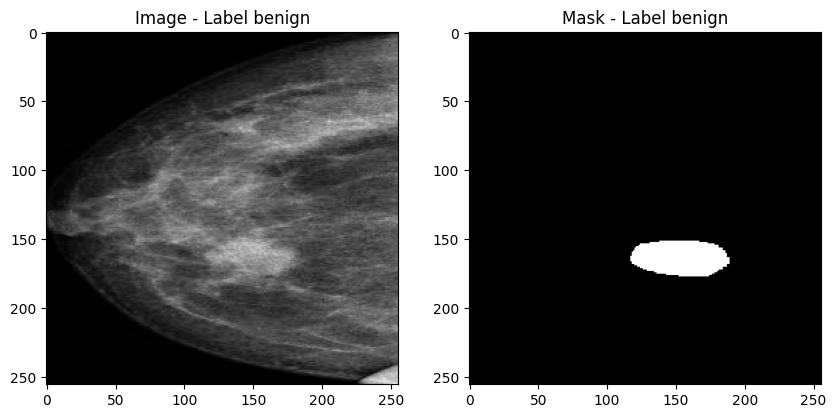

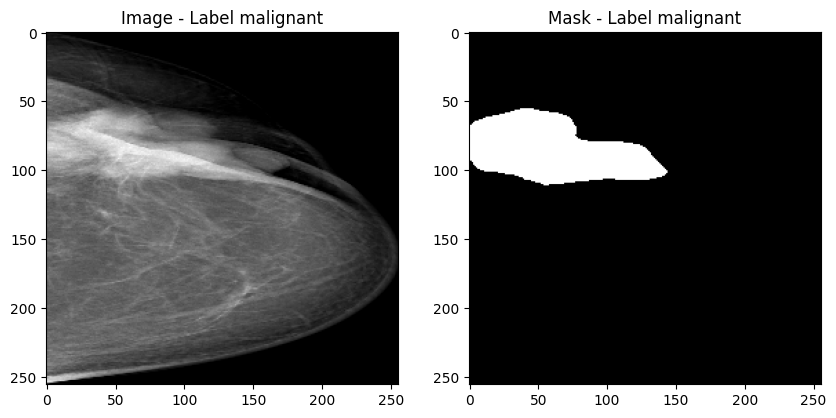

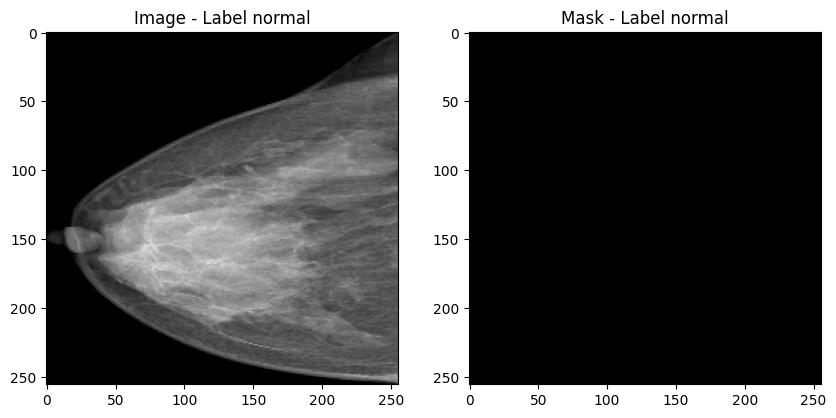

In [ ]:
def plot_images_masks(label, num_images=1):
    label_indices = np.where(labels == label)[0]
    random_indices = np.random.choice(label_indices, size=min(num_images, len(label_indices)), replace=False)

    for i, index in enumerate(random_indices):
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(images[index])
        plt.title(f'Image - Label {labeler(label)}')

        plt.subplot(1, 2, 2)
        plt.imshow(np.squeeze(masks[index]), cmap='grey')
        plt.title(f'Mask - Label {labeler(label)}')

        plt.show()

plot_images_masks(0)
plot_images_masks(1)
plot_images_masks(2)

## Train, Validation, and Test Split

We decided to manually create the train test split since the data was already randomized previously during pre-processing, and we were having difficulties with the packaged train/test split functions. This split features 70% training data, 15% validation data and, 15% test data. Since the dataset is relatively small, we needed to allocate as much data as possible to training to avoid issues with the model such as underfitting.



In [ ]:
n = len(images)
train = int(n * 0.7)
val = int(n * .15)
test = n - train - val

train_data = [images[:train], masks[:train], labels[:train]]
val_data = [images[train:train+val], masks[train:train+val], labels[train:train+val]]
test_data  = [images[train+val:], masks[train+val:], labels[train+val:]]

X_train, y_train = train_data[0], train_data[1]
X_val, y_val = val_data[0], val_data[1]
X_test, y_test = test_data[0], test_data[1]

## Baseline CNN Model

The CNN class defines a Convolutional Neural Network model optimized for image segmentation. It extends the keras.Model class, making it simple to build, train, and apply the model to predict segmentation masks. When initialized, the class configures the network architecture with keras.Sequential, which consists of multiple layers, each serving a specific purpose. Convolutional layers extract meaningful features from the input image, while max pooling layers reduce spatial dimensions, allowing the model to focus on key patterns. To return the image to its original size, upsampling layers increase the spatial dimensions of the feature maps. Next, the output layer uses a sigmoid activation function to create a single-channel mask, which results in the predicted segmentation. Finally, during the forward pass, the input image is passed through the defined network, which processes it layer by layer and outputs a segmentation mask.


In [ ]:
import keras
from keras import layers

class CNN(keras.Model):
    def __init__(self):
        super().__init__()
        self.net = keras.Sequential([
                layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3), padding='same'),
                layers.MaxPool2D((2, 2), padding='same'), #add padding
                layers.Conv2D(64, (3, 3), activation='relu', padding='same'), #add padding
                layers.MaxPool2D((2, 2), padding='same'), #add padding
                layers.Conv2D(64, (3, 3), activation='relu', padding='same'), #add padding

                # Upsampling layers to restore original image size
                layers.UpSampling2D((2, 2)),
                layers.Conv2D(32, (3, 3), activation='relu', padding='same'), #add padding
                layers.UpSampling2D((2, 2)),

                # Output layer with sigmoid activation for binary masks
                layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')
                ])

        self.net.summary()


    def call(self, input):
        x = self.net(input)
        return x

This cell creates an instance of the CNN class, which we defined earlier. This instance, named model, now represents our CNN model and holds all its layers and configurations.

In [ ]:
model = CNN()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 256, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 256, 256, 1)         │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 75,073 (293.25 KB)

 Trainable params: 75,073 (293.25 KB)

 Non-trainable params: 0 (0.00 B)

This cell compiles the CNN model, preparing it for training. It specifies optimizer adam, the loss function binary_crossentropy, and accuracy as a metric to track during training.

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

This cell starts the training process for the CNN model by providing it with the necessary data and parameters by using X_train as the input images and y_train as the corresponding target masks, running for 10 epochs. During training, the model’s performance is evaluated using validation data (X_test and y_test), and the training history, which includes the loss and other metric values over the epochs, is stored in the history variable for later analysis.

In [ ]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 230s 9s/step - accuracy: 0.9106 - loss: 0.4633 - val_accuracy: 0.9673 - val_loss: 0.1233
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 270s 10s/step - accuracy: 0.9643 - loss: 0.1215 - val_accuracy: 0.9673 - val_loss: 0.0995
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 261s 10s/step - accuracy: 0.9616 - loss: 0.1117 - val_accuracy: 0.9673 - val_loss: 0.0906
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 270s 10s/step - accuracy: 0.9619 - loss: 0.0995 - val_accuracy: 0.9673 - val_loss: 0.0897
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 248s 10s/step - accuracy: 0.9641 - loss: 0.0909 - val_accuracy: 0.9673 - val_loss: 0.0889
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 245s 10s/step - accuracy: 0.9637 - loss: 0.0908 - val_accuracy: 0.9673 - val_loss: 0.0885
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 250s 10s/step - accuracy: 0.9619 - loss: 0.0925 - val_accuracy: 0.9673 - val_loss: 0.0832
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 262s 10s/step - accuracy: 0.9649 - loss: 0.0830 - val_accuracy: 0.9

This cell defines the function plot_learning and calling it which will plot learning curve based on the training history. It displays the training and validation loss over epochs, visualizing the model's learning progress and potential overfitting.

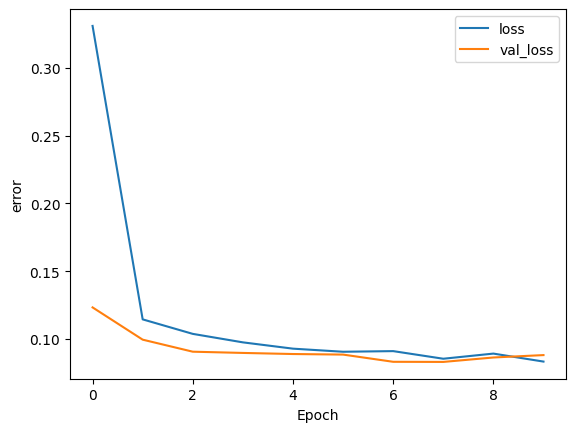

In [ ]:
def plot_learning(history, tgt='loss', val_tgt='val_loss', ylab='error'):
    plt.plot(history.history[tgt], label=tgt)
    plt.plot(history.history[val_tgt], label=val_tgt)
    plt.xlabel('Epoch')
    plt.ylabel(ylab)
    plt.legend()
plot_learning(history)
plt.show()

This cell evaluates the trained CNN model on the test data, X_test and y_test, then calculates the loss and accuracy on the test set and prints the test accuracy. This provides a final assessment of the model's performance on unseen data.

In [ ]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)
print('\nTest accuracy:', test_acc)

6/6 - 13s - 2s/step - accuracy: 0.9607 - loss: 0.0881

Test accuracy: 0.9607494473457336


This cell generates predictions using the trained CNN model on the test data and visualizes the results. It displays the original test images, true masks, and predicted masks for a subset of the test dataset. This visualization helps to understand the model's performance and potential areas of improvement.

6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step


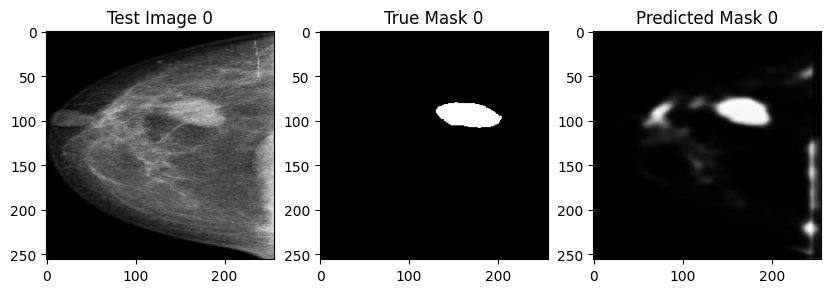

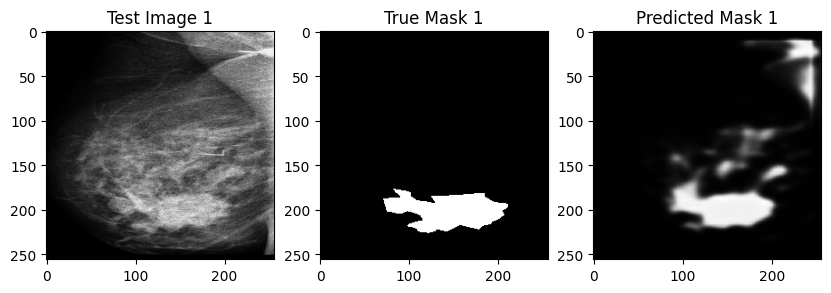

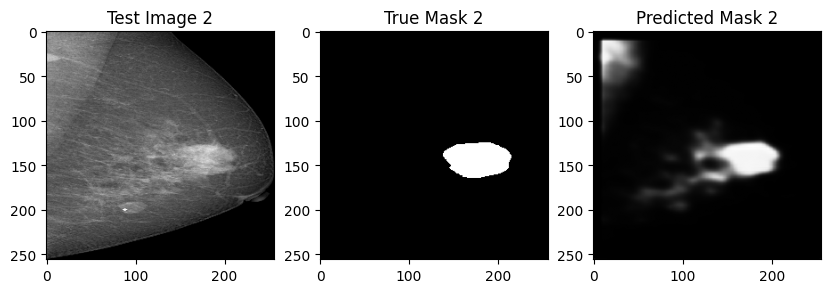

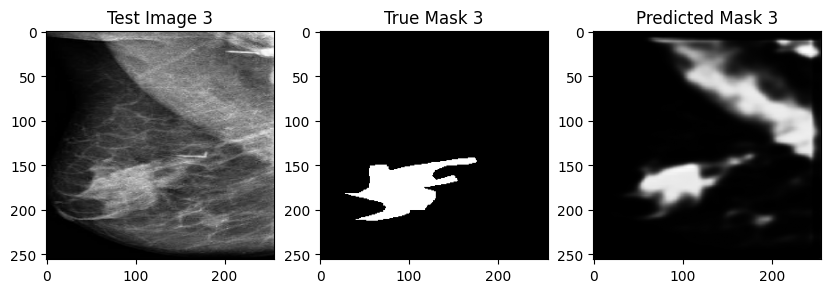

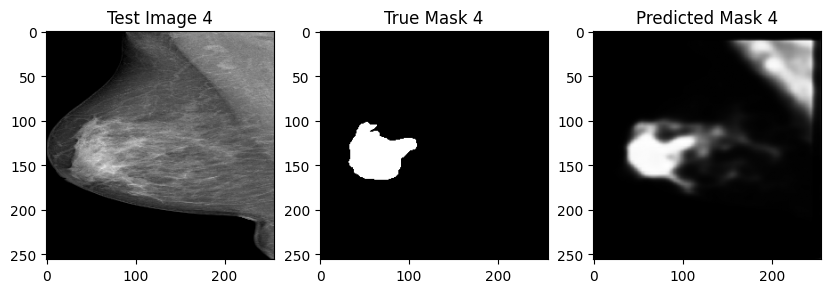

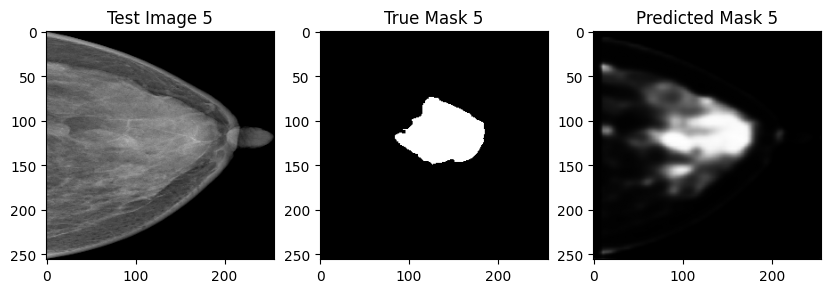

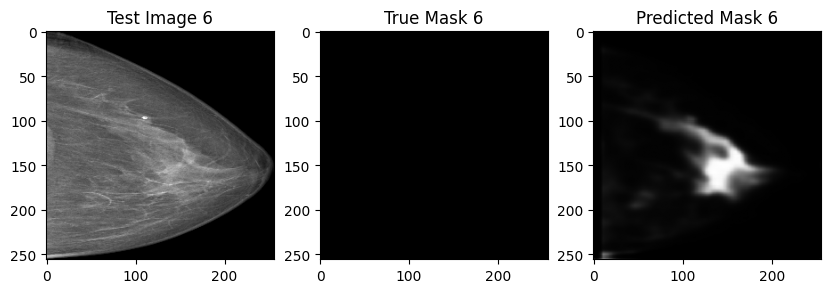

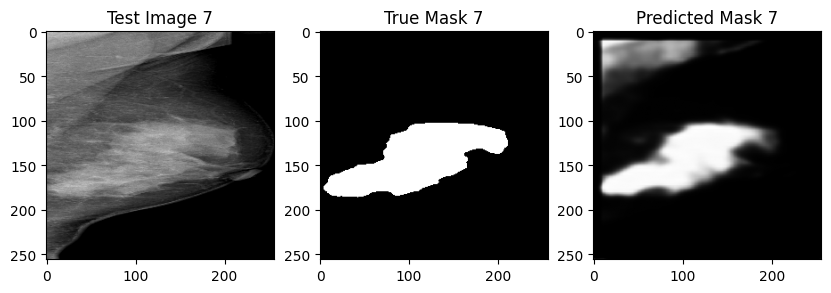

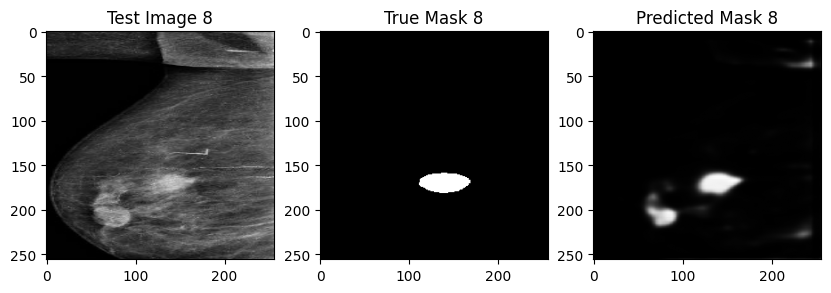

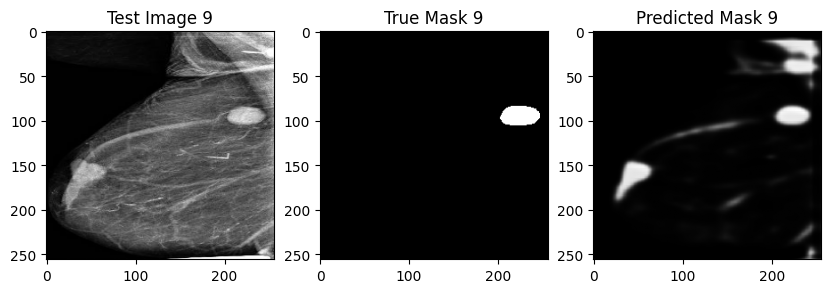

In [ ]:

predictions = model.predict(X_test)

for i in range(10):
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 3, 1)
  plt.imshow(X_test[i])
  plt.title(f'Test Image {i}')
  plt.subplot(1, 3, 2)
  plt.imshow(y_test[i], cmap='gray')
  plt.title(f'True Mask {i}')
  plt.subplot(1, 3, 3)
  plt.imshow(predictions[i], cmap='gray')
  plt.title(f'Predicted Mask {i}')
  plt.show()


This cell initializes a pre-trained ResNet18 model using weights from ImageNet. The ResNet18 architecture is a popular choice for image classification tasks and provides a strong baseline for this project.

In [ ]:

resnet_model = resnet18(weights=ResNet18_Weights.DEFAULT)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 51.2MB/s]


This cell prepares the training, validation, and test data for the ResNet model. It assigns the original images (X) and corresponding labels (y) to their respective datasets. This step ensures the data is properly formatted and organized for use with the ResNet model.

In [ ]:
X_train, y_train = train_data[0], train_data[2]
X_val, y_val = val_data[0], val_data[2]
X_test, y_test = test_data[0], test_data[2]

 This cell defines image transformations using torchvision.transforms, applies them to the data, and creates PyTorch datasets and data loaders for training, validation, and testing.

In [ ]:

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def transform_data(data):
    transformed_data = []
    for img in data:
        transformed_data.append(transform(img))
    return torch.stack(transformed_data)

x_train_tensor = transform_data(X_train)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

x_val_tensor = transform_data(X_val)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

x_test_tensor = transform_data(X_test)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


This cell trains the ResNet model using the prepared data loaders and optimizer. It iterates through epochs, calculates loss and accuracy, and updates model parameters. The training process is monitored by displaying training and validation metrics for each epoch.

In [ ]:
for param in resnet_model.parameters():
    param.requires_grad = False

num_ftrs = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_ftrs, 3)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.fc.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model.to(device)
num_epochs = 10

for epoch in range(num_epochs):
    resnet_model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in tqdm(train_loader):
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()

      outputs = resnet_model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item() * inputs.size(0)
      _, predicted = torch.max(outputs, 1)
      total_samples += labels.size(0)
      correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct_predictions / total_samples

    resnet_model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = resnet_model(val_inputs)
            val_loss += criterion(val_outputs, val_labels).item() * val_inputs.size(0)
            _, val_predicted = torch.max(val_outputs, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()
    val_loss /= len(val_loader.dataset)
    val_acc = val_correct / val_total

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

100%|██████████| 24/24 [01:17<00:00,  3.23s/it]


Epoch 1/10, Train Loss: 1.0824, Train Acc: 0.4653, Val Loss: 1.1294, Val Acc: 0.4049


100%|██████████| 24/24 [01:15<00:00,  3.15s/it]


Epoch 2/10, Train Loss: 0.9604, Train Acc: 0.5360, Val Loss: 1.0469, Val Acc: 0.4540


100%|██████████| 24/24 [01:13<00:00,  3.08s/it]


Epoch 3/10, Train Loss: 0.9072, Train Acc: 0.5819, Val Loss: 0.9884, Val Acc: 0.5031


100%|██████████| 24/24 [01:14<00:00,  3.09s/it]


Epoch 4/10, Train Loss: 0.9050, Train Acc: 0.5754, Val Loss: 0.9538, Val Acc: 0.5276


100%|██████████| 24/24 [01:15<00:00,  3.14s/it]


Epoch 5/10, Train Loss: 0.8776, Train Acc: 0.5845, Val Loss: 0.9608, Val Acc: 0.5153


100%|██████████| 24/24 [01:14<00:00,  3.10s/it]


Epoch 6/10, Train Loss: 0.8406, Train Acc: 0.6094, Val Loss: 0.9513, Val Acc: 0.5583


100%|██████████| 24/24 [01:13<00:00,  3.07s/it]


Epoch 7/10, Train Loss: 0.8365, Train Acc: 0.6186, Val Loss: 0.9518, Val Acc: 0.5337


100%|██████████| 24/24 [01:15<00:00,  3.13s/it]


Epoch 8/10, Train Loss: 0.8096, Train Acc: 0.6409, Val Loss: 0.9885, Val Acc: 0.5399


100%|██████████| 24/24 [01:14<00:00,  3.08s/it]


Epoch 9/10, Train Loss: 0.8124, Train Acc: 0.6252, Val Loss: 0.9322, Val Acc: 0.5644


100%|██████████| 24/24 [01:14<00:00,  3.09s/it]


Epoch 10/10, Train Loss: 0.7843, Train Acc: 0.6409, Val Loss: 0.9770, Val Acc: 0.5276
